# Complex Networks Activity: Synthetic Networks Analysis
## Community Structure Characterization in Stochastic Block Models
This notebook analyzes synthetic networks generated with the Stochastic Block Model (SBM) using different community detection algorithms.

In [92]:
    import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
from networkx.algorithms.community import greedy_modularity_communities, modularity
from networkx import community as nx_community
from sklearn.metrics import normalized_mutual_info_score
from collections import defaultdict
import infomap
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from sklearn.metrics import jaccard_score

np.random.seed(42)

## Data Loading and Helper Functions

In [93]:
def read_net_file(filename):
    G = nx.Graph()
    with open(filename, 'r') as f:
        lines = f.readlines()
    nodes_section, edges_section = False, False
    for line in lines:
        line = line.strip()
        if line.startswith('*vertices'):
            nodes_section, edges_section = True, False
            continue
        elif line.startswith('*edges'):
            nodes_section, edges_section = False, True
            continue
        if nodes_section:
            parts = line.split()
            if parts:
                G.add_node(int(parts[0]))
        elif edges_section:
            parts = line.split()
            if len(parts) >= 2:
                G.add_edge(int(parts[0]), int(parts[1]))
    return G

def jaccard_index(true_partition, pred_partition):
    """Calcola lo Jaccard Index per le partizioni di comunità"""
    # Converti le partizioni in array di etichette
    nodes = sorted(true_partition.keys())
    true_labels = [true_partition[node] for node in nodes]
    pred_labels = [pred_partition[node] for node in nodes]

    # Calcola lo Jaccard Index (macro average per problemi multiclasse)
    return jaccard_score(true_labels, pred_labels, average='macro')

def detect_infomap(G):
    im = infomap.Infomap("--two-level --silent")
    node_mapping = {node: idx for idx, node in enumerate(sorted(G.nodes()))}

    # Add all nodes first to handle isolates
    for node in sorted(G.nodes()):
        im.add_node(node_mapping[node])

    # Add edges
    for u, v in G.edges():
        im.add_link(node_mapping[u], node_mapping[v])

    im.run()

    # Create community mapping
    community_dict = defaultdict(set)
    for node in G.nodes():
        infomap_id = node_mapping[node]
        community_id = im.get_modules().get(infomap_id, -1)
        community_dict[community_id].add(node)

    # Convert to partition dictionary
    partition = {}
    for comm_id, nodes in community_dict.items():
        for node in nodes:
            partition[node] = comm_id

    return partition

def detect_louvain(G):
    return nx_community.louvain_communities(G, resolution=1, seed=42)

def detect_greedy(G):
    return list(greedy_modularity_communities(G))

## Metric Calculation Functions

In [94]:
def calculate_metrics(G, partition, true_partition):
    """Calculate all required metrics"""
    # Convert to consistent format
    if isinstance(partition, dict):
        # Crea lista di set per modularità
        communities = defaultdict(set)
        for node, comm_id in partition.items():
            communities[comm_id].add(node)
        communities = list(communities.values())
    else:
        communities = partition
    
    # Calcola tutte le metriche
    node_order = sorted(G.nodes())
    true_labels = [true_partition[node] for node in node_order]
    
    # Crea pred_labels in base al tipo di partizione
    if isinstance(partition, dict):
        pred_labels = [partition[node] for node in node_order]
    else:
        pred_labels = np.zeros(len(node_order), dtype=int)
        for i, comm in enumerate(communities):
            for node in comm:
                pred_labels[node_order.index(node)] = i
                
    return {
        'num_communities': len(communities),
        'modularity': nx_community.modularity(G, communities),
        'nmi': normalized_mutual_info_score(true_labels, pred_labels),
        'jaccard': jaccard_score(true_labels, pred_labels, average='macro')
    }

## Main Analysis Pipeline

In [95]:
def process_file(filename, data_dir):
    prr = float(filename.split('_')[7])
    
    G = read_net_file(os.path.join(data_dir, filename))
    true_partition = {node: (node-1)//60 for node in G.nodes()}
    
    file_results = []
    for algo_name, detector in [('Infomap', detect_infomap),
                                ('Louvain', detect_louvain),
                                ('Greedy', detect_greedy)]:
        partition = detector(G)
        metrics = calculate_metrics(G, partition, true_partition)
        file_results.append({
            'prr': prr,
            'algorithm': algo_name,
            **metrics
        })
    return file_results

data_dir = 'data'
filenames = sorted([f for f in os.listdir(data_dir) if f.endswith('.net')])

with tqdm_joblib(total=len(filenames), desc="Analyzing nets") as progress_bar:
    nested_results = Parallel(n_jobs=-1)(
        delayed(process_file)(filename, data_dir)
        for filename in filenames
    )

results = [result for sublist in nested_results for result in sublist]

Analyzing nets:   0%|          | 0/50 [00:00<?, ?it/s]

## Visualization of Results

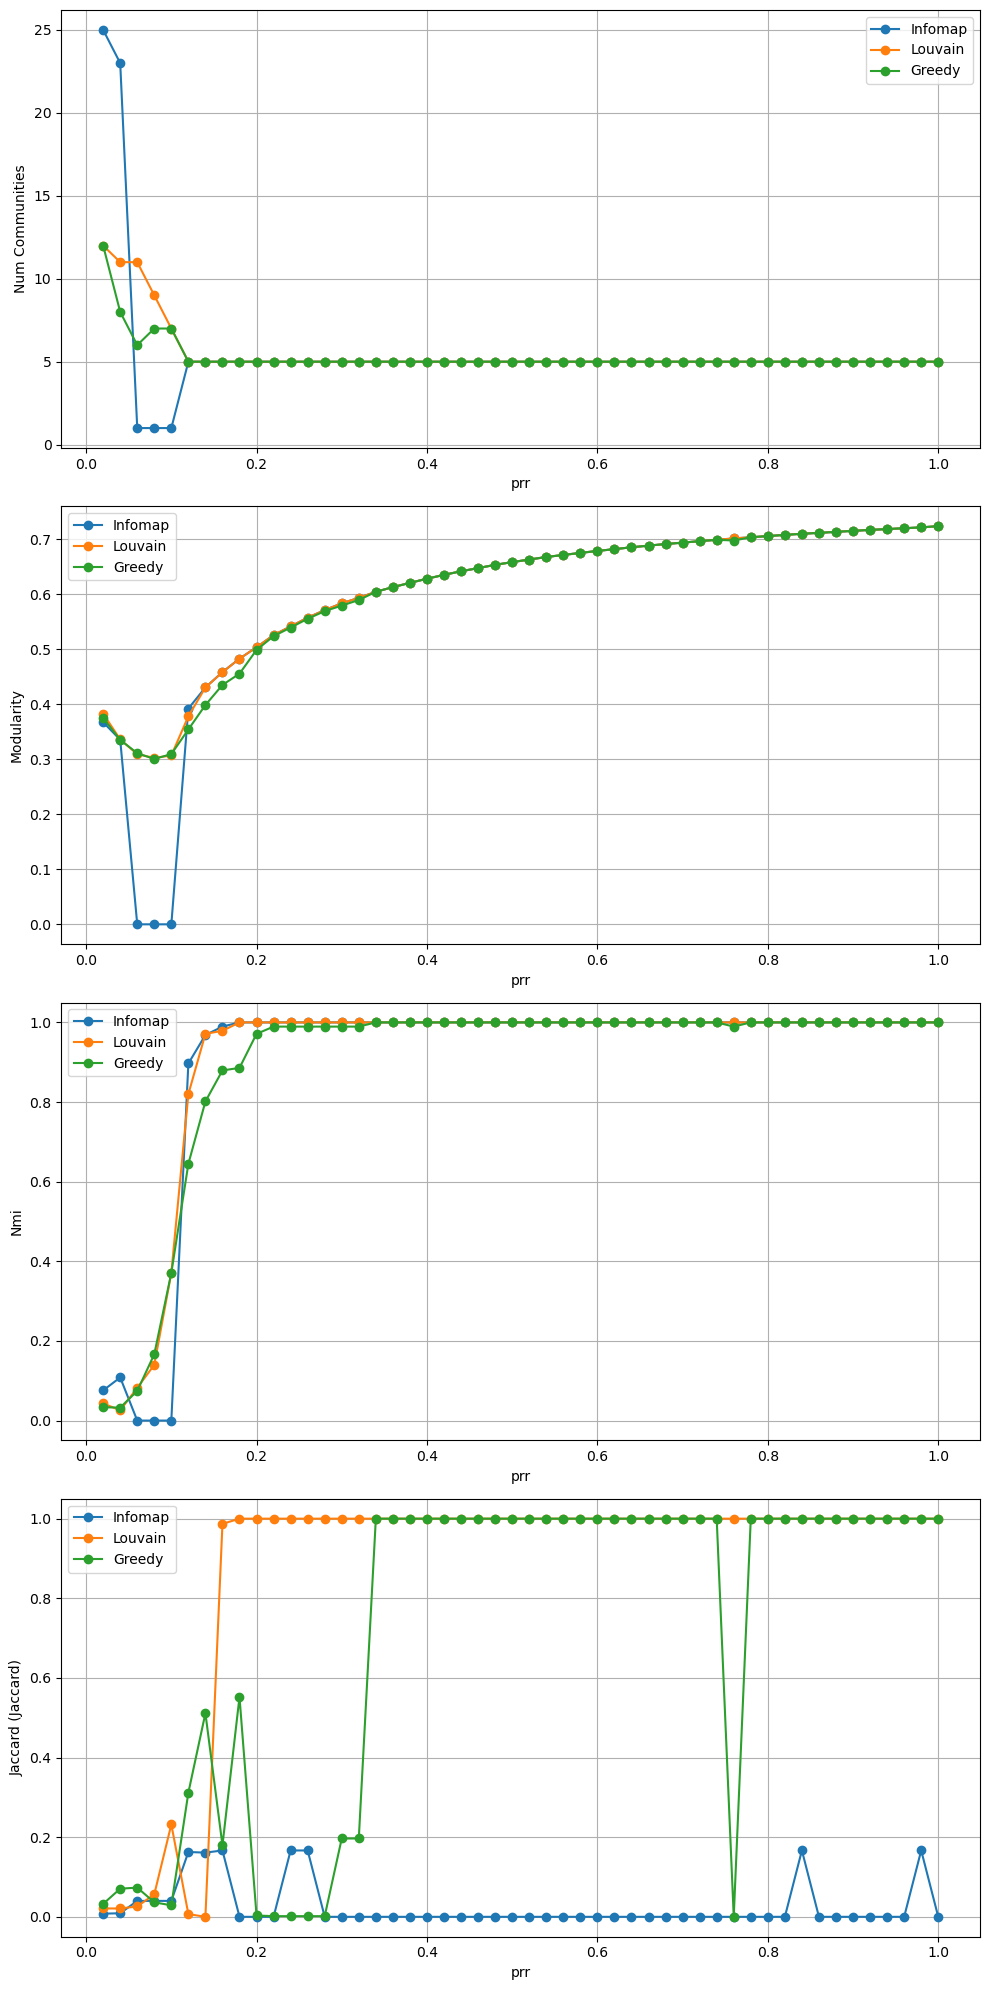

In [96]:
def plot_metrics(results):
    # Ordina le metriche correttamente
    metrics = ['num_communities', 'modularity', 'nmi', 'jaccard']
    
    # Crea subplots per 4 metriche
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))
    
    for ax, metric in zip(axes, metrics):
        # Usa solo i nomi degli algoritmi reali
        for algo in ['Infomap', 'Louvain', 'Greedy']:
            # Filtra i risultati per algoritmo
            algo_data = [r for r in results if r['algorithm'] == algo]
            
            # Ordina per prr
            sorted_data = sorted(algo_data, key=lambda x: x['prr'])
            prrs = [d['prr'] for d in sorted_data]
            values = [d[metric] for d in sorted_data]
            
            ax.plot(prrs, values, label=algo, marker='o')
        
        ax.set_xlabel('prr')
        ax.set_ylabel(metric.replace('_', ' ').title() + (' (Jaccard)' if metric == 'jaccard' else ''))
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_metrics(results)

## Network Visualization

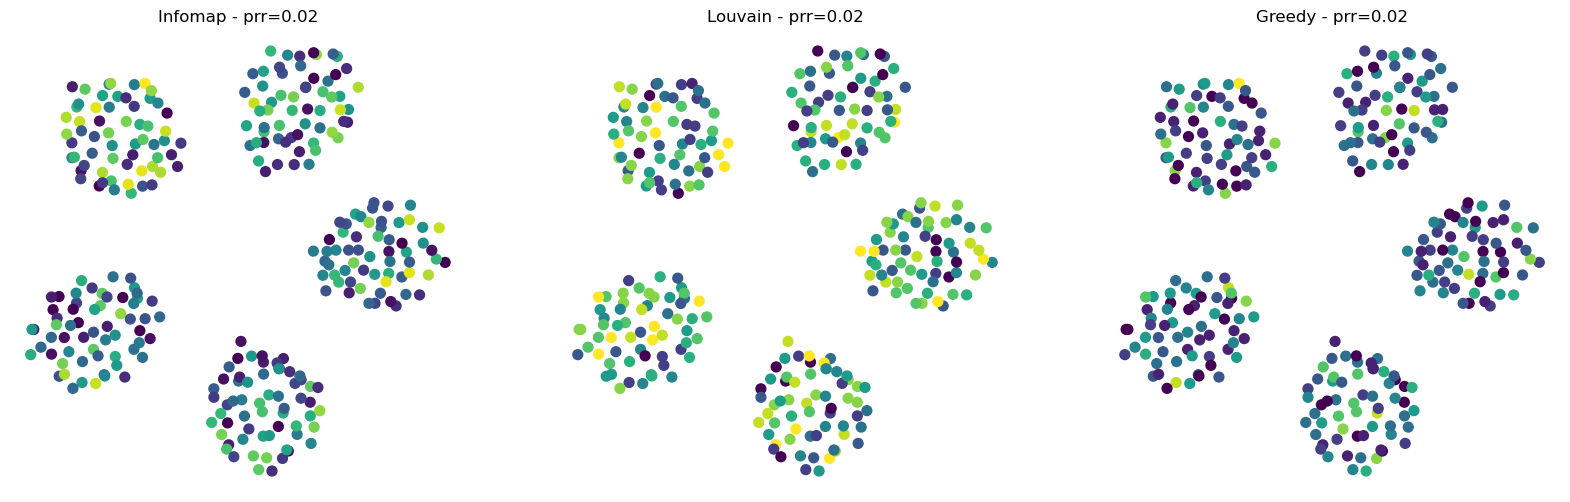

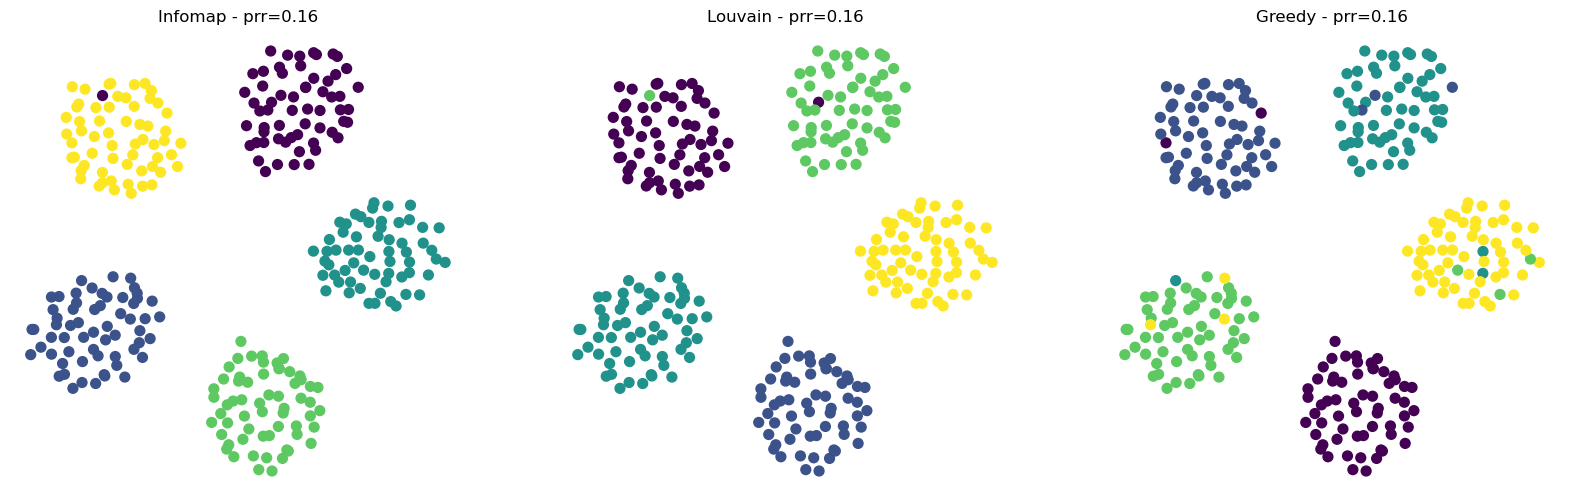

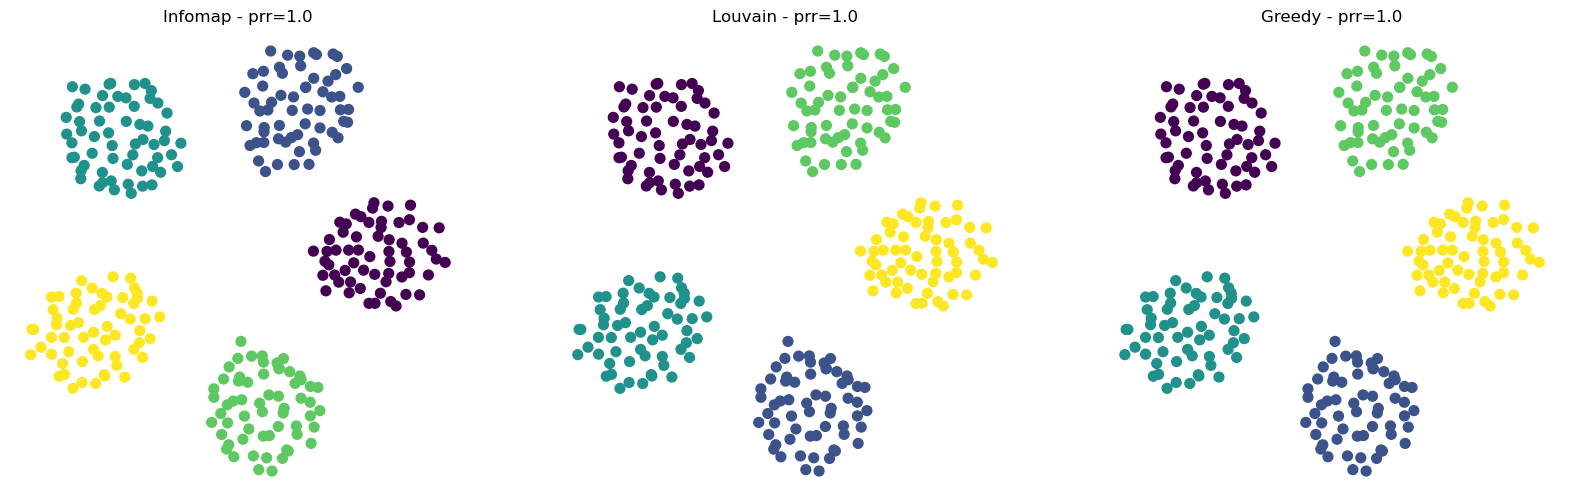

In [97]:
def visualize_networks():
    target_prrs = [0.02, 0.16, 1.0]
    layout = nx.spring_layout(read_net_file(os.path.join(data_dir, 
        'synthetic_network_N_300_blocks_5_prr_1.00_prs_0.02.net')), seed=42)
    
    for prr in target_prrs:
        filename = f'synthetic_network_N_300_blocks_5_prr_{prr:.2f}_prs_0.02.net'
        G = read_net_file(os.path.join(data_dir, filename))
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        for ax, (algo_name, detector) in zip(axes, [('Infomap', detect_infomap),
                                                 ('Louvain', detect_louvain),
                                                 ('Greedy', detect_greedy)]):
            partition = detector(G)
            if not isinstance(partition, list):
                partition = [nodes for comm in set(partition.values()) 
                            for nodes in [ [k for k,v in partition.items() if v == comm]]]
            colors = [next((i for i, comm in enumerate(partition) if node in comm), -1)
                     for node in G.nodes()]
            nx.draw_networkx_nodes(G, layout, node_color=colors, ax=ax, node_size=50)
            ax.set_title(f'{algo_name} - prr={prr}')
            ax.axis('off')
        plt.show()

visualize_networks()

## Discussion

### Limitations of Modularity
Modularity has inherent resolution limits and can show high values even in random networks. A Q=0.4 doesn't necessarily indicate significant community structure without statistical validation.

### Algorithm Comparison
Infomap typically finds more granular communities compared to modularity-based methods. Louvain and Greedy Modularity show similar trends but differ in optimization strategies, leading to varying resolution limits in community detection.